# 1.2 Age Prediction with Encoded Images

In [1]:
from glob import glob
import os as os
import matplotlib.pyplot as plt  
import matplotlib as mpl  
import numpy as np  
import pandas as pd
import scipy as scipy

import keras as keras
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras import backend as K
from keras.callbacks import TensorBoard

import matplotlib.image as mpimg
from scipy.ndimage.morphology import binary_fill_holes, binary_closing, binary_dilation  

plt.rcParams['figure.figsize'] = (10, 6)  

Using TensorFlow backend.


In [2]:
subject_annotations = pd.read_table('subject_annotations.txt')
sample_annotations = pd.read_table('sample_annotations.txt')

sample_id_list = sample_annotations['SAMPID']
sample_id_dict = {}

# Create dictionary of slide/subject ID and corresponding index in txt doc
for i in range(0, len(sample_id_list)):
    sample_id = sample_id_list[i]
    sample_id_shortened = sample_id[0:sample_id.rfind("-", 0, sample_id.rfind("-"))]
    sample_id_dict[sample_id_shortened] = i
    
subject_id_list = subject_annotations['SUBJID']
subject_id_dict = {}    
for i in range(0, len(subject_id_list)):
    subject_id = subject_id_list[i]
    subject_id_dict[subject_id] = i

def get_label_array(cat):
    """
    Return age category as Multilabel classification format
    """
    if cat == "20-29":
        return [1,0,0,0,0,0]
    elif cat == "30-39":
        return [0,1,0,0,0,0]
    elif cat == "40-49":
        return [0,0,1,0,0,0]
    elif cat == "50-59":
        return [0,0,0,1,0,0]
    elif cat == "60-69":
        return [0,0,0,0,1,0]
    elif cat == "70-79":
        return [0,0,0,0,0,1]

In [3]:
def generate_tile_img_matrix(data_type, slide_type):
    '''
    Iterates through tiles and returns:
    1. Array of image matrices 
    2. Array of age corresponding to tile image
    '''
    read_slides_path = "data/" + data_type + "/" + slide_type + "s/"
    tiles = glob(read_slides_path + "*.png")    
    
    img_matrix_array = []
    age_array = []
    
    for tile in tiles:
        
        # append image matrix
        tile_data = mpimg.imread(tile)
        img_matrix_array.append(tile_data)
        
        # read slide name from tile [slide_name]_[slide_index].png 
        slide_name = tile[tile.rfind('/')+1:tile.rfind('_')]
        
        subject_id = slide_name[:slide_name.rfind('-')]
        
        row_index = subject_id_dict[subject_id]
        
        age_label_array = get_label_array(subject_annotations.iloc[[row_index]]['AGE'].values[0])
        age_array.append(age_label_array)
    
    return img_matrix_array, age_array

In [4]:
# generate image matrices for each slide and data type
liver_test_data, liver_test_labels = generate_tile_img_matrix("validation", "liver")
lung_test_data, lung_test_labels = generate_tile_img_matrix("validation", "lung")
liver_train_data, liver_train_labels = generate_tile_img_matrix("train", "liver")
lung_train_data, lung_train_labels = generate_tile_img_matrix("train", "lung")

In [5]:
# generate train data
lung_train_data = np.asarray(lung_train_data)
liver_train_data = np.asarray(liver_train_data)
lung_train_labels = np.asarray(lung_train_labels)
liver_train_labels = np.asarray(liver_train_labels)

x_train = np.concatenate((lung_train_data, liver_train_data))
y_train = np.concatenate((lung_train_labels, liver_train_labels))

In [6]:
# generate test data
lung_test_data = np.asarray(lung_test_data)
liver_test_data = np.asarray(liver_test_data)
lung_test_labels = np.asarray(lung_test_labels)
liver_test_labels = np.asarray(liver_test_labels)

x_test = np.concatenate((lung_test_data, liver_test_data))
y_test = np.concatenate((lung_test_labels, liver_test_labels))

In [7]:
#sanity check
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5354, 128, 128, 3)
(5354, 6)
(1378, 128, 128, 3)
(1378, 6)


In [8]:
encoding_dim = 1024

# this is our input placeholder
input_img = Input(shape=(128,128,3))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

encoded = Dense(encoding_dim, activation='relu')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
__________

Above model based on Babara Engelhert's Image Pipeline
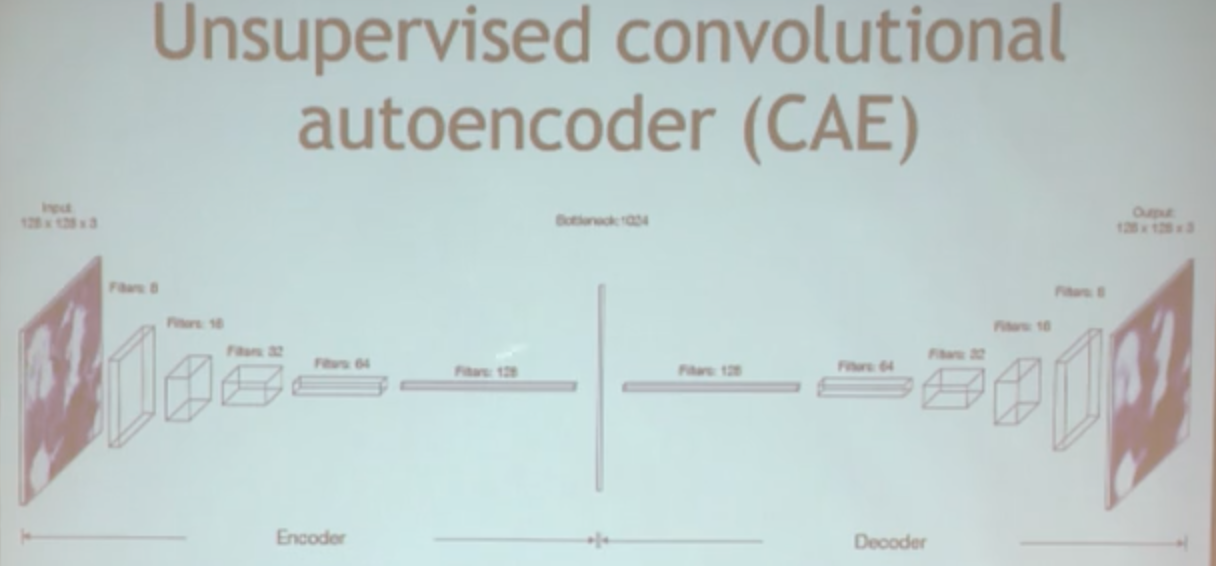

In [9]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=16,
                shuffle=True)

Epoch 1/10
5354/5354 [==============================] - 9s - loss: 0.6487     
Epoch 2/10
5354/5354 [==============================] - 7s - loss: 0.6335     
Epoch 3/10
5354/5354 [==============================] - 7s - loss: 0.6293     - ETA: 0s - loss: 0.62
Epoch 4/10
5354/5354 [==============================] - 7s - loss: 0.6270     
Epoch 5/10
5354/5354 [==============================] - 7s - loss: 0.6259     
Epoch 6/10
5354/5354 [==============================] - 7s - loss: 0.6250     
Epoch 7/10
5354/5354 [==============================] - 7s - loss: 0.6243     
Epoch 8/10
5354/5354 [==============================] - 7s - loss: 0.6238     
Epoch 9/10
5354/5354 [==============================] - 7s - loss: 0.6233     
Epoch 10/10
5354/5354 [==============================] - 7s - loss: 0.6231     


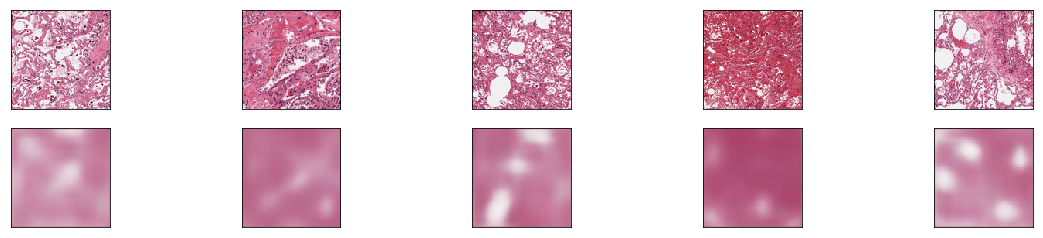

In [19]:
decoded_imgs = autoencoder.predict(x_test)

n = 5  # how many tiles we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
encoder = Model(input_img, encoded)

X_train_new = np.array(encoder.predict(x_train))
X_test_new = np.array(encoder.predict(x_test))

print(X_train_new.shape)
print(X_test_new.shape)

(5354, 4, 4, 1024)
(1378, 4, 4, 1024)


In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(4,4,1024)))
model.add(MaxPooling2D((2, 2)))
model.add(Dense(256, activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4, 4, 1024)        1049600   
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 1024)        0         
_________________________________________________________________
dense_3 (Dense)              (None, 2, 2, 256)         262400    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
dense_4 (Dense)              (None, 1, 1, 64)          16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
__________

In [16]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',
              optimizer=sgd)

model.fit(X_train_new, y_train, epochs=20, batch_size=16)

Epoch 1/20
5354/5354 [==============================] - 2s - loss: 0.3522     
Epoch 2/20
5354/5354 [==============================] - 2s - loss: 0.3512     
Epoch 3/20
5354/5354 [==============================] - 2s - loss: 0.3505     
Epoch 4/20
5354/5354 [==============================] - 2s - loss: 0.3508     
Epoch 5/20
5354/5354 [==============================] - 2s - loss: 0.3499     
Epoch 6/20
5354/5354 [==============================] - 2s - loss: 0.3493     
Epoch 7/20
5354/5354 [==============================] - 2s - loss: 0.3496     
Epoch 8/20
5354/5354 [==============================] - 2s - loss: 0.3485     
Epoch 9/20
5354/5354 [==============================] - 2s - loss: 0.3483     
Epoch 10/20
5354/5354 [==============================] - 2s - loss: 0.3488     
Epoch 11/20
5354/5354 [==============================] - 2s - loss: 0.3481     
Epoch 12/20
5354/5354 [==============================] - 2s - loss: 0.3477     
Epoch 13/20
5354/5354 [==========================

In [17]:
preds = model.predict(X_test_new)
print(preds)

[[ 0.06243314  0.06890299  0.14175083  0.31339926  0.47110167  0.0032509 ]
 [ 0.06710255  0.07008073  0.17646469  0.35999933  0.3422457   0.00342157]
 [ 0.06824015  0.07037226  0.13712671  0.33149725  0.40391794  0.00243396]
 ..., 
 [ 0.02045214  0.04191042  0.06708605  0.51129311  0.39727187  0.00245424]
 [ 0.01894076  0.03948058  0.06271042  0.51185507  0.40858543  0.00226546]
 [ 0.0256271   0.04955062  0.086682    0.49848861  0.35560107  0.00309015]]


In [18]:
preds[preds>=0.5] = 1
preds[preds<0.5] = 0
preds.astype(int)

## Get Accuracy of SGD prediction
counter = 0
for i in range(len(preds)):
    if set(preds[i]) == set(y_test[i]):
        counter +=1
print(counter/len(preds))

0.23294629898403482
